In [53]:
%reset -f
from parflow import Run
from parflow.tools.fs import get_absolute_path
from parflow.tools.io import write_pfb, read_pfb
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch.utils.data import TensorDataset
from utils import init_location, cal_z_locid, cal_velz_loc, \
                  interpolate_vel, data_normalize, To_Tensor_ode
# from parflow.tools.hydrology import calculate_water_table_depth, \
# calculate_overland_flow_grid, calculate_overland_fluxes
# %matplotlib widget

In [54]:
# used to generate data for neural ODE
p_start = 35040
t_start = 0 #iteration start
t_end = 500 #iteration end
selectd = np.array([18,19,3,4,18,19])
#0-20,0-5,0-20 because this is actually 0-19,0-4,0-19 for fortran array

npcell = 10  #used for train
testsize = 1  #used for test
npcell = npcell + testsize  #all
# how many particles in a grid cell

interval = 1 #always no gap
step_size = 1 #always one hour

In [55]:
# input model parameters
nx = 20
ny = 5
nz = 20

dx = 5
dy = 0.2
dz = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, \
               0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.3, 0.1])

boundings = np.array([0., 100., 0., 1., 0., 9.4])
# nx = 41
# ny = 41
# nz = 50

# dx = 1000
# dy = 1000
# dz = np.ones((50))*2

# boundings = np.array([0., 41000., 0., 41000., 0., 100])

In [56]:
for ii in range(t_start,t_end):
    
    # istept = 1 + ii #current iterate step
    istept = 1 #fixed step
    
    # file_prefix = '../neurcomp_3D/volumes/LW'
    # file_prefix = '../neurcomp_3D/volumes/LW'
    file_prefix = './vel_field/hillslope_clm_ER_shrub'

    Vx = read_pfb(get_absolute_path(file_prefix+'.out.velx.'+str(istept+p_start).zfill(5)+'.pfb'))
    Vy = read_pfb(get_absolute_path(file_prefix+'.out.vely.'+str(istept+p_start).zfill(5)+'.pfb'))
    Vz = read_pfb(get_absolute_path(file_prefix+'.out.velz.'+str(istept+p_start).zfill(5)+'.pfb'))
    Saturation = read_pfb(get_absolute_path(file_prefix+'.out.satur.'+str(istept+p_start).zfill(5)+'.pfb'))
    Porosity = read_pfb(get_absolute_path(file_prefix+'.out.porosity.pfb'))
    
    if ii%100 == 0:
        print('ii',ii)

    if ii == t_start:
        
        #setup initial location
        initx,inity,initz = init_location(npcell,nx,ny,nz,dx,dy,dz)
        # initz[1,0,:,:]

        #cal locid
        Px = np.copy(initx)
        Py = np.copy(inity)
        Pz = np.copy(initz)

    Plocx = np.floor(Px/dx)
    Plocy = np.floor(Py/dy)
    Plocz = cal_z_locid(npcell,nx,ny,nz,dz,Pz)

    # cal vel loc
    # this can be got by random number directly
    # but for multiple steps, we still need to calculate
    # so we provide the template here
    # we may also calculate it from random number
    # i mean like add the intial fraction with the new_distance/vel
    # but additional other calculation may need

    Clocx = (Px - Plocx*dx)/dx
    Clocy = (Py - Plocy*dy)/dy
    Clocz = cal_velz_loc(npcell,nx,ny,nz,dz,Pz,Plocz)

    Vpx, Vpy, Vpz = interpolate_vel(npcell,nx,ny,nz,Plocx,Plocy,Plocz,Clocx,Clocy,Clocz, \
                                   Vx,Vy,Vz,Saturation,Porosity)

    # only move those in the selected area
    Px[:,selectd[0]:selectd[1],selectd[2]:selectd[3],selectd[4]:selectd[5]] = \
    Px[:,selectd[0]:selectd[1],selectd[2]:selectd[3],selectd[4]:selectd[5]] + \
    Vpx[:,selectd[0]:selectd[1],selectd[2]:selectd[3],selectd[4]:selectd[5]]
    
    Py[:,selectd[0]:selectd[1],selectd[2]:selectd[3],selectd[4]:selectd[5]] = \
    Py[:,selectd[0]:selectd[1],selectd[2]:selectd[3],selectd[4]:selectd[5]] + \
    Vpy[:,selectd[0]:selectd[1],selectd[2]:selectd[3],selectd[4]:selectd[5]]
    
    Pz[:,selectd[0]:selectd[1],selectd[2]:selectd[3],selectd[4]:selectd[5]] = \
    Pz[:,selectd[0]:selectd[1],selectd[2]:selectd[3],selectd[4]:selectd[5]] + \
    Vpz[:,selectd[0]:selectd[1],selectd[2]:selectd[3],selectd[4]:selectd[5]]

    tt,initx1,inity1,initz1,Px1,Py1,Pz1 = data_normalize(ii,interval,step_size,t_start,t_end, \
                                                   initx,inity,initz,Px,Py,Pz,boundings)

    particles_train_new = To_Tensor_ode(0,npcell-testsize,selectd[0],selectd[2],selectd[4], \
                                        selectd[1],selectd[3],selectd[5],initx1,inity1,initz1,Px1,Py1,Pz1,ii)
    particles_test_new = To_Tensor_ode(npcell-testsize,npcell,selectd[0],selectd[2],selectd[4], \
                                   selectd[1],selectd[3],selectd[5],initx1,inity1,initz1,Px1,Py1,Pz1,ii)
    
    if ii == t_start:
        
        particles_train = particles_train_new
        particles_test  = particles_test_new
        
    else:
        
        particles_train = torch.cat((particles_train, particles_train_new),dim=1)        
        particles_test  = torch.cat((particles_test, particles_test_new),dim=1)
    

ii 0
ii 100
ii 200
ii 300
ii 400


In [64]:
print(particles_train.shape,particles_test.shape)
torch.save(particles_train,'./ode/particles_train.pth')
torch.save(particles_test,'./ode/particles_test.pth')

torch.Size([10, 501, 3]) torch.Size([1, 501, 3])


In [68]:
data_train = torch.load('./ode/particles_train.pth')

b = data_train[2,:,:]
a = b.numpy()
print(a)

# b = data_train[:][1]
# c = b.numpy()

# b = data_train[:][2]
# t = b.numpy()
# len(t)

[[0.8003468  0.55237645 0.94949424]
 [0.8003443  0.5523755  0.9492615 ]
 [0.8003418  0.5523745  0.94902784]
 ...
 [0.7992967  0.551717   0.78763646]
 [0.79929507 0.5517163  0.7873364 ]
 [0.79929346 0.5517157  0.7870366 ]]


Text(0.5, 0, 'z')

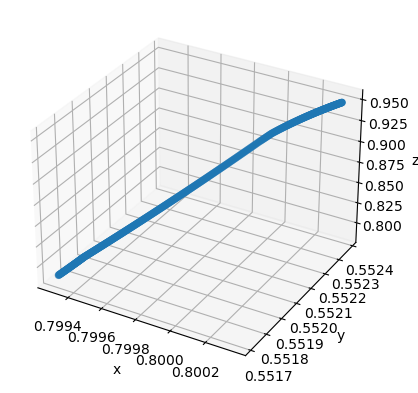

In [69]:
# import time
# fig = plt.figure()
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
# for ii in range(600):
# ii =0:10
# xline = c[ii,0]
# yline = c[ii,1]
# zline = c[ii,2]
xline0 = a[:,0]
yline0 = a[:,1]
zline0 = a[:,2]
# tdata = t:
ax.plot3D(xline0, yline0, zline0, 'gray')
# ax.plot3D(xline0, yline0, zline0, 'blue')
# ax.scatter3D(xline, yline, zline, cmap='r_Blues')
ax.scatter3D(xline0, yline0, zline0, 'r_Blues')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
# time.sleep(2)
# ax.show()

In [12]:
indx = np.zeros((20,5,20))
a = np.arange(20)
indx = indx+ a[np.newaxis, np.newaxis, :]
indx[:,:,1]
# a

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])